In [234]:
import pandas as pd
import numpy as np
import datetime
import time

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
from ipywidgets import widgets

import warnings; warnings.simplefilter('ignore')

# 1. Data Cleaning

In [235]:
df1 = pd.read_csv('201811.csv')
print(df1.shape)
print(pd.isna(df1).sum()) # check NA

(1260355, 15)
tripduration                0
starttime                   0
stoptime                    0
start station id           80
start station name         80
start station latitude      0
start station longitude     0
end station id             80
end station name           80
end station latitude        0
end station longitude       0
bikeid                      0
usertype                    0
birth year                  0
gender                      0
dtype: int64


In [236]:
# Check Longitude/Latitude with missing station names

missing = df1.loc[pd.isna(df1['start station id'])].groupby(['start station latitude']).count()[['tripduration']]
missing.columns = ['count of missing data']
missing = missing.reset_index()
missing2 = df1.loc[df1['start station latitude'].isin(missing['start station latitude'])].groupby(['start station latitude']).count()[['tripduration']]
missing2.columns = ['count of all records of missing-name latitude']
missing2 = missing2.reset_index()
compare = pd.concat([missing,missing2], axis=1, join_axes=[missing.index])
compare

start station latitude  count of missing data  start station latitude  \
0                  40.842                      5                  40.842   
1                  40.845                      1                  40.845   
2                  40.851                      8                  40.851   
3                  40.854                      2                  40.854   
4                  40.857                     17                  40.857   
5                  40.860                     21                  40.860   
6                  40.863                     14                  40.863   
7                  40.866                     11                  40.866   
8                  40.869                      1                  40.869   

   count of all records of missing-name latitude  
0                                              5  
1                                              1  
2                                              8  
3                                              2  
4                                             17  
5                                             21  
6                                             14  
7                                             11  
8                                              1

Four fields have missing data. On further examination, a trip record either miss all the four fields or have full information. The longitude/latitude of these records don't appear in records that have complete information, suggesting these may not be dock stations. This is confirmed by checking a few of the longitude/latitude on CitiBike App. Therefore, remove these records from the analysis. It won't affect the result sinigificant because they only represent a small portion of the whole data set (80 out of 1,260,355).

In [237]:
df2 = df1.dropna(subset=['start station id']) 

Very short trips with the same start and end station most likely are not successful trips, likely due to bicycle malfunctioning, last-minute change of travel plan, etc. On the other hand, riders may make a short round trip for a quick errand without docking the bike at the destination. If the destination is within 5-min's walk, people are most likely to walk than to bike. Therefore, trips with the same start and end station and are less than 10 minutes in duration are considered unsuccessful trips and are removed from the analysis. 1,252,600 records remain.

In [238]:
df2['dur'] = df2['tripduration']/60
df3 = df2.loc[~((df2['dur'] < 10) & (df2['start station id'] == df2['end station id']))] 

Next, examine trip duration data to clean abnormalities.

In [239]:
df3['dur'].describe().apply(lambda x: format(x, 'f'))

count    1252600.000000
mean          14.219331
std          103.780459
min            1.016667
25%            5.666667
50%            9.366667
75%           15.983333
max        44121.433333
Name: dur, dtype: object

The longest trip lasted 44,121 minutes. Based on the current prices for monthly/annual pass, 1-day, and 3-day pass, if a subscriber rides for more than 2 hours and 15 minute, the fee for the trip will exceed the monthly pass fee; similarly, the fee break-even duration is 1 hour and 15 minutes for an 1-day pass customer and 2 hours for a 3-day pass customer. Therefore, a rational rider will limit his/her trip to shorter than the break-even duration. Considering that riders may not always be optimizing their trip durations, we loosen the standard a little and set the duration threshold as 2.5 hours. Trips longer than this are considered abnomal due to bike/dock malfunctioning or misuse, and are excluded from the analysis. 1,250,375 records remain.

In [240]:
maxdur = 60 * 2.5
df4 = df3.loc[df3['dur'] <= maxdur]
df4.shape[0]

1250375

In [241]:
# Add information needed for analysis

df4['startT']= df4['starttime'].apply(lambda x: time.strptime(x[0:19],'%Y-%m-%d %H:%M:%S')) # read start time
df4['day'] = df4['startT'].apply(lambda x: x[0:3]) # get start date
df4['h'] = df4['startT'].apply(lambda x: x[3])     # get start hour 
df4['dow'] = df4['startT'].apply(lambda x: x[6])    # get the day of week of start
df4['start station id'] = df4['start station id'].astype(int)
df4['start']= df4['start station name'] + ' ('+ df4['start station id'].astype(str) + '), ('+ df4['start station latitude'].astype(str) + ', ' + df4['start station longitude'].astype(str)+')'


# 2. Monthly Frequency of Starts by Station

In [242]:
mon_tot = df4.groupby(['start']).count()[['dur']] # group trips by start station and count the frequencies
mon_tot.columns = ['All Riders']
mon_tot = mon_tot.sort_values('All Riders', ascending=False)

print('\nTop 10 stations had ' + str(mon_tot.iloc[0:10,0].sum()) + ' trips, representing ' + str('{:.0%}'.format(mon_tot.iloc[0:10,0].sum()/mon_tot.iloc[:,0].sum())) + ' of the total trips.')
print('Top 10 popular starting station:')
print(mon_tot.head(10))


Top 10 stations had 74928 trips, representing 6% of the total trips.
Top 10 popular starting station:
                                                    All Riders
start                                                         
Pershing Square North (519), (40.75187299999999...       10443
E 17 St & Broadway (497), (40.73704984, -73.990...        8148
W 21 St & 6 Ave (435), (40.74173969, -73.99415556)        8035
Broadway & E 22 St (402), (40.740343200000005, ...        7537
Broadway & E 14 St (285), (40.73454567, -73.990...        7094
Broadway & W 60 St (499), (40.76915505, -73.981...        7073
8 Ave & W 33 St (490), (40.751551, -73.993934)            7045
8 Ave & W 31 St (3255), (40.7505853470215, -73....        6901
Lafayette St & E 8 St (293), (40.73020660529954...        6406
E 10 St & Avenue A (445), (40.72740794, -73.981...        6246


The following chart shows the monthly frequency of starts at each docking station, in descending order of frequency. You can view the station information (name, id, lat/log) and the frequency by hovering your mouse over each bar.

In [251]:
mon_tot.reset_index(inplace=True)

trace0 = go.Bar(
    y = mon_tot['All Riders'],
    text = mon_tot['start'].tolist(),
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=0.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Monthly Frequency of Starts By Station (November 2018)',
    xaxis=dict(
        title='Station Ranking by Total Frenquency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Frequency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Monthly1')

There are two types of riders, Subscriber and Customer. They may represent different trip and demand patterns. To verify this, analyze the monthly starts and duration by station and rider type.

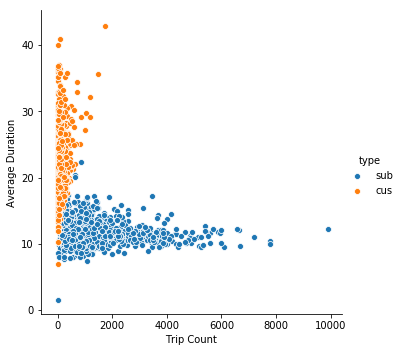

In [246]:
def monthly(df): 
    mon_totCnt = df.groupby(['start']).count()[['dur']]
    mon_totDur = df.groupby(['start']).mean()[['dur']]
    result = pd.concat([mon_totCnt, mon_totDur], axis=1, sort=False)
    result.columns = ['Trip Count','Average Duration']
    return result
sub = monthly(df4.loc[df4['usertype'] == 'Subscriber'])
sub['type'] = 'sub'
cus = monthly(df4.loc[df4['usertype'] == 'Customer'])
cus['type'] = 'cus'
byType = pd.concat([sub, cus], axis=0, sort=False)
sns.pairplot(x_vars=['Trip Count'], y_vars=['Average Duration'], data=byType, hue='type', size=5)

In [258]:
mon_cus = df4.loc[df4['usertype'] == 'Customer'].groupby(['start']).count()[['dur']]
mon_sub = df4.loc[df4['usertype'] == 'Subscriber'].groupby(['start']).count()[['dur']]
mon_tot2 = df4.groupby(['start']).count()[['dur']]
mon_all = pd.concat([mon_tot2,mon_cus,mon_sub], axis=1, join_axes=[mon_tot2.index])
mon_all.columns = ['All Riders','Customers','Subscribers']
mon_all = mon_all.sort_values('All Riders', ascending=False)
#print(mon_all.head())

The following chart shows the monthly frequency of starts by user type at each docking station, in descending order of all riders' frequency. Some stations have high frequency of one rider type even though the total frequency of all riders is relatively low. You can view this by hovering your mouse over each bar, or by double-clicking on the legend (upper-right corner) to isolate one user type.

In [259]:
mon_all.reset_index(inplace=True)

trace1 = go.Bar(
    #x = mon_all['start'].tolist(),
    y = mon_all['Customers'],
    #orientation = 'h',
    text = mon_all['start'].tolist(),
    marker=dict(
        color='rgb(244, 155, 66)',
        line=dict(
            color='rgb(244, 155, 66)',
            width=0.1,
        )
    ),
    opacity=0.8,
    name = 'Customer'
)
trace2 = go.Bar(
    #x = mon_all['start'].tolist(),
    y = mon_all['Subscribers'],
    #orientation = 'h',
    text = mon_all['start'].tolist(),
    marker=dict(
        color='rgb(15, 116, 188)',
        line=dict(
            color='rgb(15, 116, 188)',
            width=0.1,
        )
    ),
    opacity=0.8,
    name = 'Subscriber'
)

data = [trace2, trace1]
layout = go.Layout(
    title='Monthly Frequency of Starts By Station and User Type (November 2018)',
    barmode='stack',
    xaxis=dict(
        title='Station Rank by Total Frenquency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Frequency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Monthly2')

# 3. Daily Frequency of Starts by Station

In [263]:
daily1 = df4.groupby(['start','day']).count()[['dur']].unstack().transpose()
daily2 = daily1.reindex(daily1.sum().sort_values(ascending=False).index, axis=1)
daily3 = daily2.fillna(0)  # n/a means there was no trip starting at one station on a certain day. Fill n/a with 0.
daily3.head(3)

start              Pershing Square North (519), (40.751872999999996, -73.97770600000001)  \
    day                                                                                    
dur (2018, 11, 1)                                              750.0                       
    (2018, 11, 2)                                              620.0                       
    (2018, 11, 3)                                              183.0                       

start              E 17 St & Broadway (497), (40.73704984, -73.99009296)  \
    day                                                                    
dur (2018, 11, 1)                                              450.0       
    (2018, 11, 2)                                              441.0       
    (2018, 11, 3)                                              346.0       

start              W 21 St & 6 Ave (435), (40.74173969, -73.99415556)  \
    day                                                                 
dur (2018, 11, 1)                                              493.0    
    (2018, 11, 2)                                              278.0    
    (2018, 11, 3)                                              343.0    

start              Broadway & E 22 St (402), (40.740343200000005, -73.98955109)  \
    day                                                                           
dur (2018, 11, 1)                                              481.0              
    (2018, 11, 2)                                              463.0              
    (2018, 11, 3)                                              235.0              

start              Broadway & E 14 St (285), (40.73454567, -73.99074142)  \
    day                                                                    
dur (2018, 11, 1)                                              329.0       
    (2018, 11, 2)                                              390.0       
    (2018, 11, 3)                                              267.0       

start              Broadway & W 60 St (499), (40.76915505, -73.98191841)  \
    day                                                                    
dur (2018, 11, 1)                                              413.0       
    (2018, 11, 2)                                              346.0       
    (2018, 11, 3)                                              407.0       

start              8 Ave & W 33 St (490), (40.751551, -73.993934)  \
    day                                                             
dur (2018, 11, 1)                                           442.0   
    (2018, 11, 2)                                           400.0   
    (2018, 11, 3)                                           241.0   

start              8 Ave & W 31 St (3255), (40.7505853470215, -73.9946848154068)  \
    day                                                                            
dur (2018, 11, 1)                                              465.0               
    (2018, 11, 2)                                              391.0               
    (2018, 11, 3)                                              139.0               

start              Lafayette St & E 8 St (293), (40.73020660529954, -73.99102628231049)  \
    day                                                                                   
dur (2018, 11, 1)                                              419.0                      
    (2018, 11, 2)                                              337.0                      
    (2018, 11, 3)                                              211.0                      

start              E 10 St & Avenue A (445), (40.72740794, -73.98142006)  \
    day                                                                    
dur (2018, 11, 1)                                              332.0       
    (2018, 11, 2)                                              335.0       
    (2018, 11, 3)                                              215.0       

start     

The box chart below shows the daily frequency of starts by station, in descending order of total monthly frequency. For each station, you can view the values of daily start as they spread across the entire month by zooming in and panning (tool bar in the top right corner) and hovering your mouse over each box.

In [264]:
from numpy import *
N = 761
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 210, N)]

data = [{
    'y': daily2.iloc[:,i], 
    'type':'box',
    'marker':{'color': c[i]},
    'name': str(list(daily2)[i]),
    'showlegend': False
    } for i in range(int(N))]


layout = go.Layout(
    title='Daily Frequency of Trip Starts By Station (November 2018)',
    
    xaxis=dict(
        title='Station Rank by Total Frenquency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Frequency of Starts',
        titlefont=dict(
            family='Courier New, monospace',
            size=14,
            color='#7f7f7f'
        )
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='DailyFrequency')

The daily frequency of starts fluctuates significantly throughout the month at some locations while remains relatively stable at some other locations. One potential reason is the difference in customer base. For instance, subscribers are most likely commuters, therefore stations that primarily serve subscribers tend to be busier on non-holiday weekdays; customers are more likely visitors and tourists, therefore stations that are most popular among customers tend to be busier on weekend and holidays. 

The chart below shows the daily frequency of starts by station, user type, and type of day (non-holiday weekdays, weekend, holiday). In the two drop-down menus, you can choose station and type of day separately.

In [265]:
df5 = df4[['start station name','start','day','dow','usertype']]
df6_tot = df5.groupby(['day','dow','start']).count()[['start station name']]
df6_cus = df5.loc[df5['usertype'] == 'Customer'].groupby(['day','dow','start']).count()[['start station name']]
df6_sub = df5.loc[df5['usertype'] == 'Subscriber'].groupby(['day','dow','start']).count()[['start station name']]
daily_all = pd.concat([df6_tot,df6_cus,df6_sub], axis=1, join_axes=[df6_tot.index])
daily_all.columns = ['All Riders','Customers','Subscribers']
daily_all.reset_index(inplace=True)
daily_all['dType'] = np.where(daily_all['day'] == (2018, 11,22),'Holiday', np.where(daily_all['day'] == (2018, 11,23),'Holiday', np.where(daily_all['dow'] < 5,'Non-holiday Weekday','Weekend')))
daily = daily_all.fillna(0)

dtype = widgets.Dropdown(
    options=list(daily['dType'].unique()),
    value='Non-holiday Weekday',
    description='Type of Day:',
)

station = widgets.Dropdown(
    options=list(daily['start'].unique()),
    value='1 Ave & E 110 St (3496), (40.7923272, -73.9383)',
    description='Start Station:'
)

# Assign an emptry figure widget with two traces

trace1 = go.Box(y=daily['Subscribers'], opacity=0.75, name='Subscriber')
trace2 = go.Box(y=daily['Customers'], opacity=0.75, name='Customer')

g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text='Daily Frequency of Starts'
                        ),
                        barmode='overlay'
                    ))

def validate():
    if station.value in daily['start'].unique() and dtype.value in daily['dType'].unique():
        return True
    else:
        return False

def response(change):
    if validate():
        filter_list = [i and j for i, j in
                           zip(daily['dType'] == dtype.value, daily['start'] == station.value)]
        temp_df = daily_all[filter_list]
        x1 = temp_df['Subscribers']
        x2 = temp_df['Customers']
        #x3 = temp_df['All Riders']
        with g.batch_update():
            g.data[0].y = x1
            g.data[1].y = x2
            #g.data[2].y = x3
            g.layout.barmode = 'overlay'
            g.layout.xaxis.title = 'Daily Frequency of Trip Starts'          


dtype.observe(response, names="value")
station.observe(response, names="value")

container = widgets.HBox([station, dtype])
widgets.VBox([container,g])

In [266]:
H = 2       # Two holidays in November 2018 : . Twenty 
nH_wk = 20  # number of 
wd = 8      # number of weekend
df4['dType'] = np.where(df4['day'] == (2018, 11,22),'H', np.where(df4['day'] == (2018, 11,23),'H', np.where(df4['dow'] < 5,'nH_wk','wd')))
df7 = df4.groupby(['usertype','dType','start']).count()[['dur']].unstack()
df7.index = df7.index.droplevel(1)
df7 = df7.transpose()
df7.columns = ['Customer_Holiday','Customer_Non-holiday_Weekday','Customer_Weekend','Subscriber_Holiday','Subscriber_Non-holiday_Weekday','Subscriber_Weekend']

dayList = [2, 20, 8]*2  # The November of 2018 has two holidays (11/22/2018 and 11/23/2018), twenty non-holiday weekdays, and eight weekend days. 
for i in range(6):
    df7.iloc[:,i] = df7.iloc[:,i] / dayList[i]

df7 = df7.fillna(0)
df7.reset_index(inplace=True)
#df7.head()

The following shows the top 5 popular stations by user type and type of day:

In [267]:
for i in range(6):
    print(str(list(df7)[i+2]) + " :")
    print(list(df7.sort_values(by=list(df7)[i+2], ascending=False)['start'][0:5]))
    

Customer_Holiday :
['Grand Army Plaza & Central Park S (281), (40.764397100000004, -73.97371465)', 'Columbus Ave & W 72 St (3164), (40.7770575, -73.97898475)', 'Central Park North & Adam Clayton Powell Blvd (3374), (40.799484, -73.955613)', '5 Ave & E 73 St (3137), (40.77282817, -73.96685276)', '5 Ave & E 88 St (3282), (40.78307, -73.95939)']
Customer_Non-holiday_Weekday :
['Grand Army Plaza & Central Park S (281), (40.764397100000004, -73.97371465)', 'Central Park S & 6 Ave (2006), (40.76590936, -73.97634151)', 'Centre St & Chambers St (387), (40.71273266, -74.0046073)', 'Broadway & W 60 St (499), (40.76915505, -73.98191841)', '5 Ave & E 73 St (3137), (40.77282817, -73.96685276)']
Customer_Weekend :
['Grand Army Plaza & Central Park S (281), (40.764397100000004, -73.97371465)', 'Central Park S & 6 Ave (2006), (40.76590936, -73.97634151)', 'Broadway & W 60 St (499), (40.76915505, -73.98191841)', 'Centre St & Chambers St (387), (40.71273266, -74.0046073)', '5 Ave & E 88 St (3282), (40.7

# 4. Mapping Manhattan Stations Showing Monthly frequency of Trip Starts

In [231]:
# Export data for mapping in QGIS

mon_all.to_csv('monMap.csv')

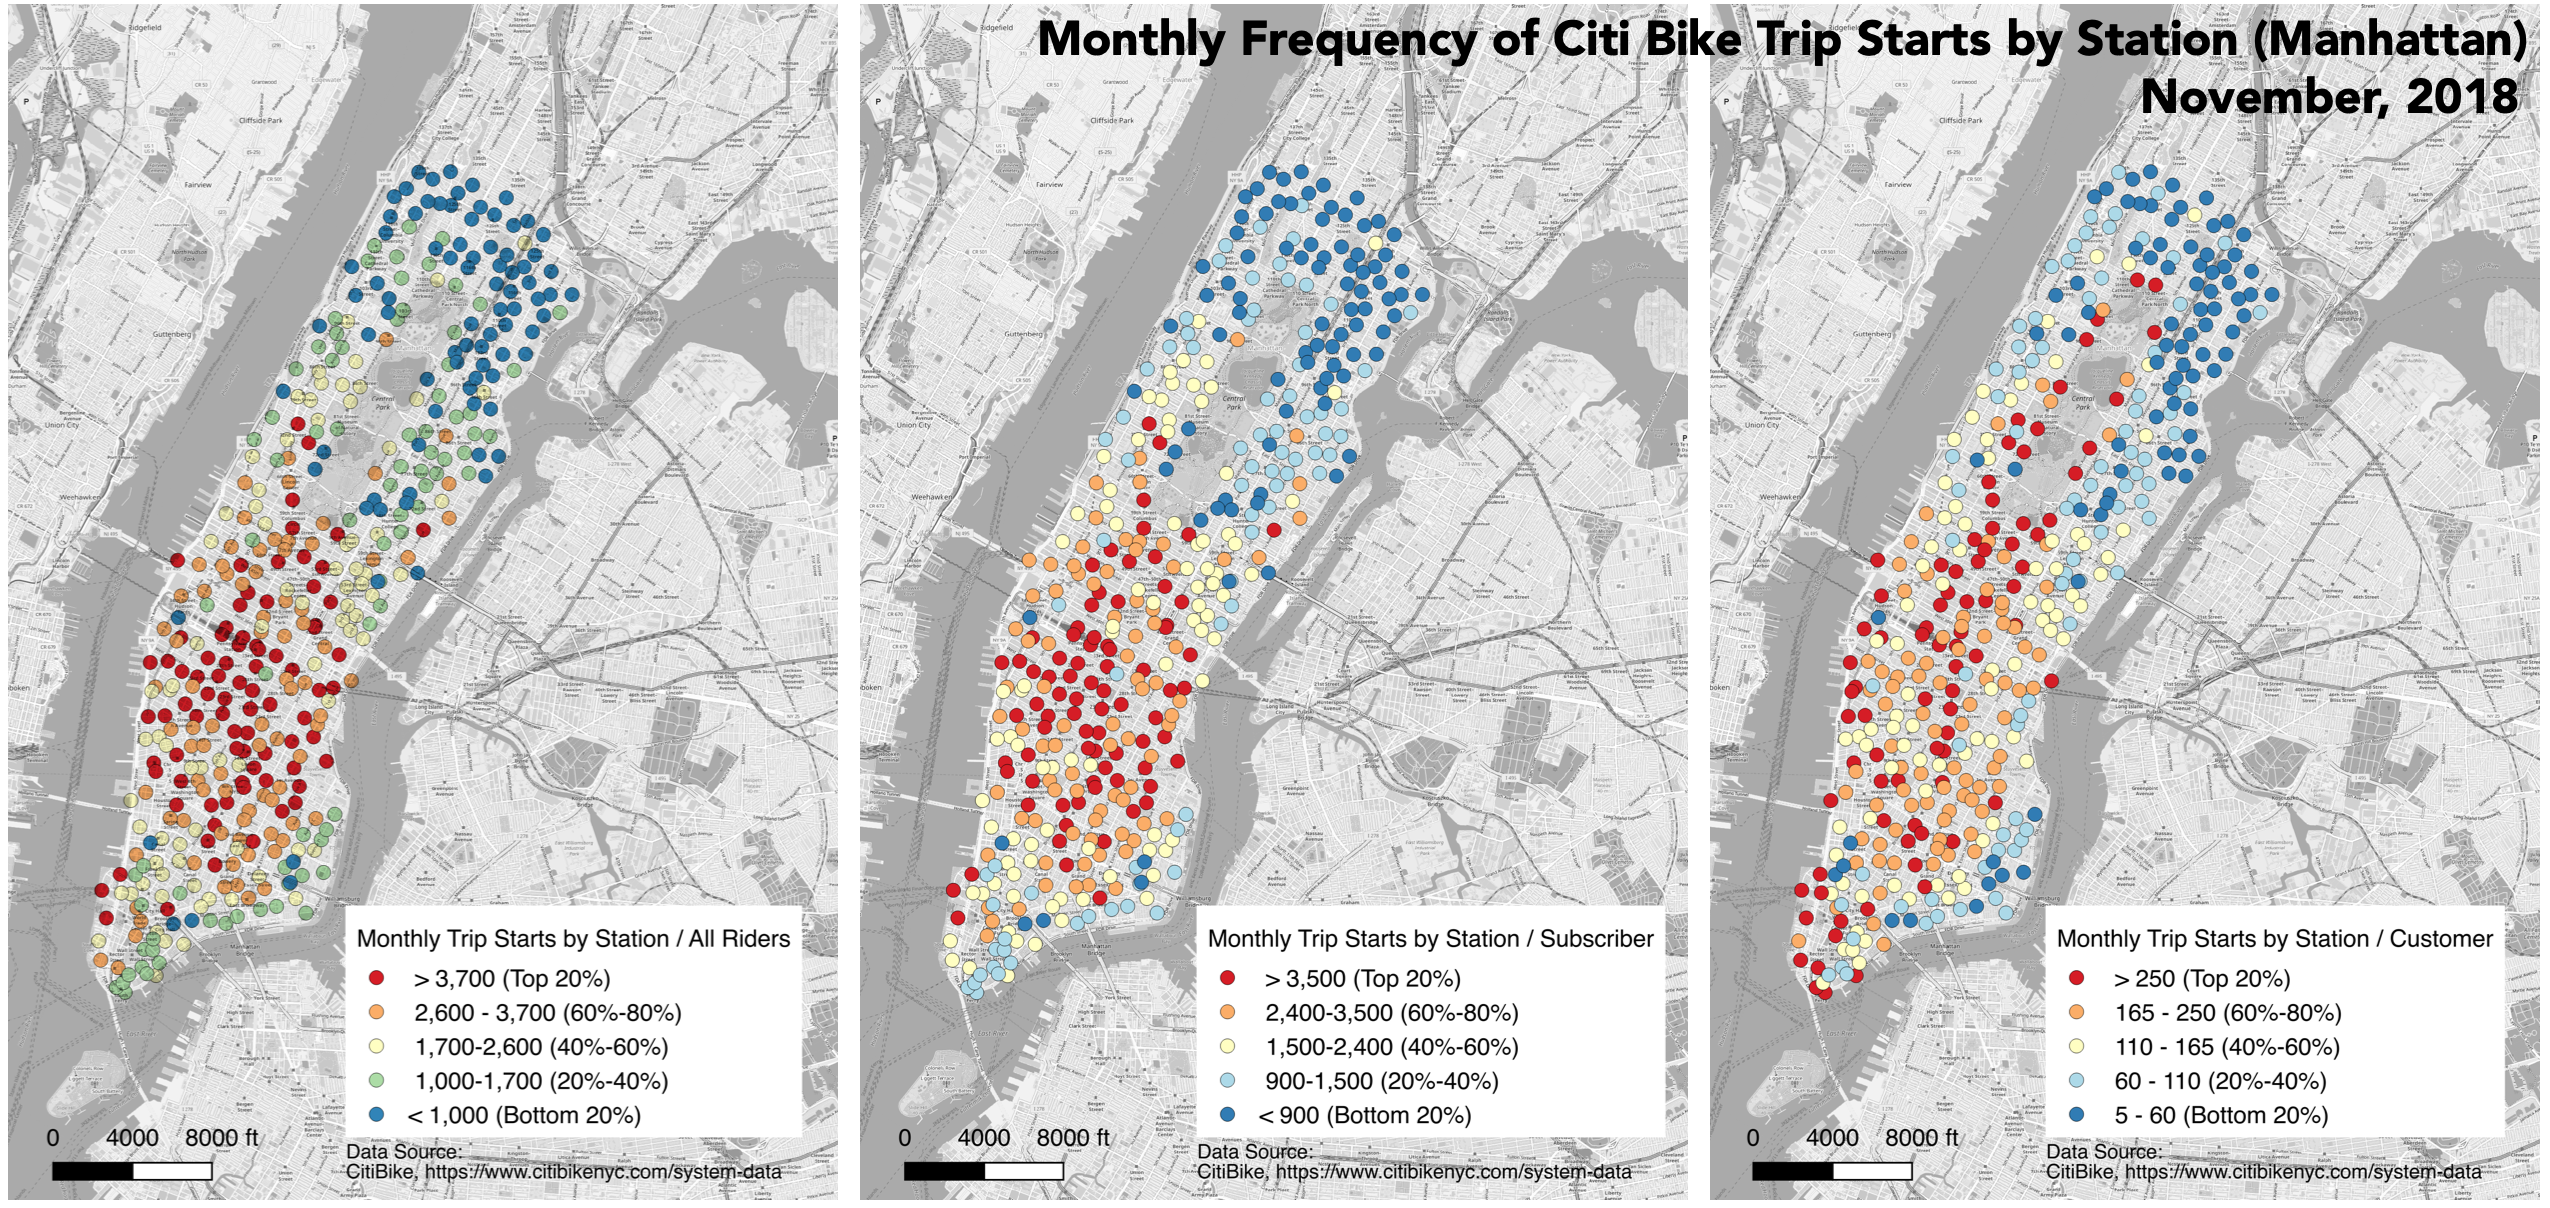

In [211]:
from IPython.display import Image
Image(filename='map.png')

The map is also available in the Github folder '/maps' (https://github.com/yuqimit/citi_bike_2019).

The same folder also contains a dynamic map: '/maps/index.html'. Load the map in your browser, then hover your mouse over each station to view the monthly frequency of total trip starts, as well as trip starts by user type.

# 5. Summary of Trends

First, trip demand varies in different neighborhoods of Manhattan. Overall, stations in Midtown and Downtown are the busiest. The stations in Lower Manhattan are less busy, and stations in Uptown are the least busy. The 20 most population stations (3% of all stations) represent 11% of all trip starts in the month of November 2018. Second, 93% of all trips were made by subscribers, most of whom are commuters. Only 7% of all trips were made by customers, most of whom are likely visitors. Third, the busiest subscriber trip starting stations are mainly concentrated in the employment centers in Midtown and Downtown. In contrast, the majority of the busiest customer trip starting stations are located near tourist destinations such as Central Park and Lower Manhattan waterfront. Fourth, trip demand varies with the type of day: stations mainly serving subscribers are busier on non-holiday weekdays than on holidays and weekend; stations that attract customers are busier on holidays and weekend. Fifth, subscriber trips tend to be shorter and less varied across stations: the average subscriber trip duration at different stations concentrate in the 5 – 20 minutes range; the average customer trips duration at different stations ranges from less than 10 minutes to over 40 minutes.

# 6. Other Open Datasets

Census data: demographic data at Block Groups level - population density, population age distribution, household vehicle ownership, household income.

Census “OnTheMap” data: commute pattern.

City data: land use, bike lane infrastructure, GTFS, tourist destinations.

Potentially available through FOIA request: household travel pattern survey, The New York Best Practice Model (NYBPM).